# Competencia de modelos de Predicción para el número de vehículos registrados en el Sistema RUNT

Intregrantes
- Cristian Alejandro Rojas Mazo
- Sebastian Lopez Mazo
- Kevin Danilo Arias Buitrago 
- Santiago Carvajal Torres
- Juan David Pino Ramirez

In [1]:
import pandas as pd
import numpy as np
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 22.3 MB/s 
     |████████████████████████████████| 262 kB 1.8 MB/s 
     |████████████████████████████████| 1.7 MB 50.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 36.1 MB/s 
     |████████████████████████████████| 56 kB 3.1 MB/s 
     |████████████████████████████████| 88 kB 5.3 MB/s 
     |████████████████████████████████| 167 kB 46.4 MB/s 
     |████████████████████████████████| 6.8 MB 41.6 MB/s 
     |████████████████████████████████| 2.0 MB 46.5 MB/s 
     |████████████████████████████████| 10.4 MB 34.2 MB/s 
     |████████████████████████████████| 17.9 MB 439 kB/s 
     |████████████████████████████████| 122 kB 12.4 MB/s 
     |████████████████████████████████| 

In [1]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
#importe de librerias
import pandas as pd
import numpy as np
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import joblib 

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
#importe de librerias
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score as r2
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.model_selection import GridSearchCV

In [5]:
#Lectura Datos de registro de Autos
DataRegistros = pd.read_excel('registros_autos_entrenamiento.xlsx',parse_dates = ['Fecha'])
DataRegistros.head()

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159


In [6]:
#Lectura Datos de días de fines de semana y festivos
Df_NBD = pd.read_csv('NonBussinesDays.csv',parse_dates = ['Fecha'])
Df_NBD.head()

,Unnamed: 0,Fecha
0,0,2012-01-01
1,1,2012-09-01
2,2,2012-03-19
3,3,2012-01-04
4,4,2012-05-04


In [7]:
#Se agrega columna correspondiente a los dias fines de semana y festivos
DataRegistros['NonBussinessDay'] = DataRegistros['Fecha'].apply(lambda x : 1 if x in Df_NBD['Fecha'].unique() else 0)
DataRegistros.head()

,Fecha,Unidades,NonBussinessDay
0,2012-01-01,0,1
1,2012-01-02,188,0
2,2012-01-03,482,0
3,2012-01-04,927,1
4,2012-01-05,1159,1


Aparece la nueva columna Nonbussinessday, esta corresponde a un valor de 1 sí el día es festivo o sabado o domingo

In [9]:
# Agregamos columnas 

#Días
DataRegistros['Day']= pd.DatetimeIndex(DataRegistros['Fecha']).day
#Día de la semana
DataRegistros['Dayweek'] = DataRegistros['Fecha'].dt.day_name()
#Mes
DataRegistros['Month']= pd.DatetimeIndex(DataRegistros['Fecha']).month
#Año
DataRegistros['Year']= pd.DatetimeIndex(DataRegistros['Fecha']).year

DataRegistros.head()

,Fecha,Unidades,NonBussinessDay,Day,Dayweek,Month,Year
0,2012-01-01,0,1,1,Sunday,1,2012
1,2012-01-02,188,0,2,Monday,1,2012
2,2012-01-03,482,0,3,Tuesday,1,2012
3,2012-01-04,927,1,4,Wednesday,1,2012
4,2012-01-05,1159,1,5,Thursday,1,2012


Ahora el data frame contiene 7 columnas, 5 de ellas obtenidas a partir de las otras

In [22]:
#Obtención del conteo anual por día para realizar un análisis descriptivo
ConteoAnualPorDía = DataRegistros.groupby(['Dayweek','Year'])[['Unidades']].sum().unstack().reindex([ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])


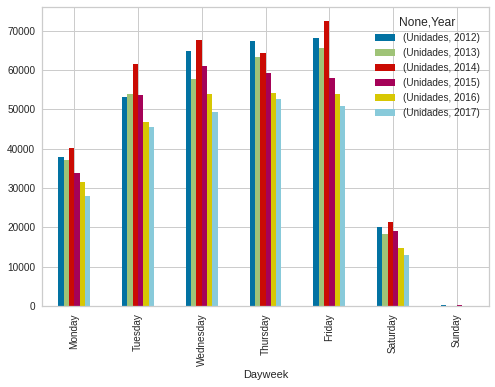

In [27]:
#Diagrama de barras para comparar las unidades a lo largo de los días
ConteoAnualPorDía.plot.bar()
plt.show()

Se puede observar que los días en general con menos registros del runt son los sabados y los domingos, esto puede ser así porque es posible que los domingos no se trabaje

In [28]:
##Diagrama de barras para comparar las unidades a lo largo de los meses
ConteoAnualPorMes = DataRegistros.groupby(['Month','Year'])['Unidades'].sum().unstack()
ConteoAnualPorMes

Year,2012,2013,2014,2015,2016,2017
Month,,,,,,
1,20390,19541,20220,21366,16829,17307
2,24840,21865,23870,23010,20380,18036
3,29217,21707,24184,24810,19849,21200
4,23945,26633,26222,21983,20415,17184
5,27066,24835,27013,22649,19580,20025
6,24691,22719,23152,22623,20742,19926
7,25638,26205,27767,26741,17652,18711
8,25988,23856,27536,23329,22553,21029
9,25557,24850,29647,25015,21497,19436


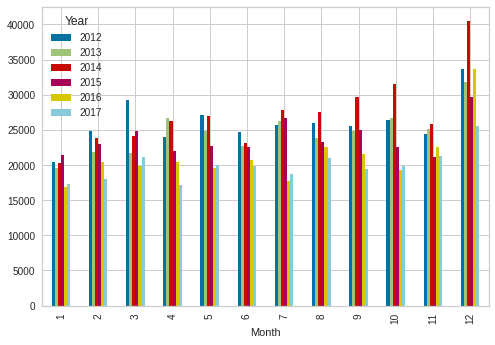

In [30]:
#Diagrama de barras para comparar las unidades a lo largo de los días
ConteoAnualPorMes.plot.bar()
plt.show()

Se puede obsevar que el mes con mayor número de registros en general es diciembre, además, diciembre registró el valor de registros más altos durante el año 2014

In [38]:
#Meses de vacaciones        
Meses_vacaciones = [1,
                    6,
                    7,
                    11,
                    12]

Se consideraron los meses de vacaciones enero, junio, julio, noviembre y diciembre, estos meses son conocidos por tener registros conocidos para la compra de automotores

Según:

- https://www.carroya.com/noticias/guias-de-compra-y-venta/las-mejores-fechas-para-comprar-carro-4411

In [40]:
#Crear columna meses de vacaciones
DataRegistros['Holidays'] = DataRegistros['Month'].apply(lambda x: 1 if x in Meses_vacaciones else 0)

In [41]:
DataRegistros = DataRegistros[['Year','Month','Day','Dayweek','NonBussinessDay','Holidays','Unidades']]
DataRegistros.head()

,Year,Month,Day,Dayweek,NonBussinessDay,Holidays,Unidades
0,2012,1,1,Sunday,1,1,0
1,2012,1,2,Monday,0,1,188
2,2012,1,3,Tuesday,0,1,482
3,2012,1,4,Wednesday,1,1,927
4,2012,1,5,Thursday,1,1,1159


In [76]:
#Datos para entrenamiento
DataRegistrosTraining = DataRegistros[DataRegistros['Year']<2017]
#Datos para testing
DataRegistrosTest = DataRegistros[DataRegistros['Year']>=2017]

Se crean 2 dataframes, 1 para entrenamiento y otro para testeo

In [77]:
DataRegistrosTraining

,Year,Month,Day,Dayweek,NonBussinessDay,Holidays,Unidades
0,2012,1,1,Sunday,1,1,0
1,2012,1,2,Monday,0,1,188
2,2012,1,3,Tuesday,0,1,482
3,2012,1,4,Wednesday,1,1,927
4,2012,1,5,Thursday,1,1,1159
...,...,...,...,...,...,...,...
1822,2016,12,27,Tuesday,0,1,1922
1823,2016,12,28,Wednesday,0,1,2409
1824,2016,12,29,Thursday,0,1,3603
1825,2016,12,30,Friday,0,1,965


In [78]:
DataRegistrosTest.shape

(365, 7)

Se puede observar que para el training se tienen 1827 filas y para el testeo se tienen 365

Se procede a utilizar la variable de pandas llamada get dummies con el objetivo de Cconvertir variables categoricas en variables indicadoras

- https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [79]:
DataRegistrosTraining = pd.get_dummies(DataRegistrosTraining)
DataRegistrosTraining.head()

,Year,Month,Day,NonBussinessDay,Holidays,Unidades,Dayweek_Friday,Dayweek_Monday,Dayweek_Saturday,Dayweek_Sunday,Dayweek_Thursday,Dayweek_Tuesday,Dayweek_Wednesday
0,2012,1,1,1,1,0,0,0,0,1,0,0,0
1,2012,1,2,0,1,188,0,1,0,0,0,0,0
2,2012,1,3,0,1,482,0,0,0,0,0,1,0
3,2012,1,4,1,1,927,0,0,0,0,0,0,1
4,2012,1,5,1,1,1159,0,0,0,0,1,0,0


In [80]:
DataRegistrosTest = pd.get_dummies(DataRegistrosTest)
DataRegistrosTest.head()

,Year,Month,Day,NonBussinessDay,Holidays,Unidades,Dayweek_Friday,Dayweek_Monday,Dayweek_Saturday,Dayweek_Sunday,Dayweek_Thursday,Dayweek_Tuesday,Dayweek_Wednesday
1827,2017,1,1,1,1,0,0,0,0,1,0,0,0
1828,2017,1,2,0,1,45,0,1,0,0,0,0,0
1829,2017,1,3,0,1,116,0,0,0,0,0,1,0
1830,2017,1,4,1,1,232,0,0,0,0,0,0,1
1831,2017,1,5,1,1,455,0,0,0,0,1,0,0


In [81]:
DataRegistrosTest.reset_index(inplace = True)
DataRegistrosTraining.reset_index(inplace =  True)

In [82]:
DataRegistrosTest = DataRegistrosTest.drop(['index'], axis = 1)
DataRegistrosTraining = DataRegistrosTraining.drop(['index'], axis = 1)

In [84]:
DataRegistrosTraining.head()

,Year,Month,Day,NonBussinessDay,Holidays,Unidades,Dayweek_Friday,Dayweek_Monday,Dayweek_Saturday,Dayweek_Sunday,Dayweek_Thursday,Dayweek_Tuesday,Dayweek_Wednesday
0,2012,1,1,1,1,0,0,0,0,1,0,0,0
1,2012,1,2,0,1,188,0,1,0,0,0,0,0
2,2012,1,3,0,1,482,0,0,0,0,0,1,0
3,2012,1,4,1,1,927,0,0,0,0,0,0,1
4,2012,1,5,1,1,1159,0,0,0,0,1,0,0


In [85]:
DataRegistrosTest.to_csv('DatosTesteo.csv', index = False, encoding = 'utf-8')

In [86]:
#values de las columnas
ValoresColumna = list(DataRegistrosTraining.columns.values)
#Se dropea la Variable Target
ValoresColumna.remove('Unidades')

In [87]:
#verificacion
ValoresColumna

['Year',
 'Month',
 'Day',
 'NonBussinessDay',
 'Holidays',
 'Dayweek_Friday',
 'Dayweek_Monday',
 'Dayweek_Saturday',
 'Dayweek_Sunday',
 'Dayweek_Thursday',
 'Dayweek_Tuesday',
 'Dayweek_Wednesday']

Se cuenta con 12 variables

In [89]:
DatosSetup = setup(data = DataRegistrosTraining, target = 'Unidades', numeric_features = ValoresColumna , normalize = True, session_id = 101)

,Description,Value
0,session_id,101
1,Target,Unidades
2,Original Data,"(1827, 13)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1278, 12)"


In [90]:
#Comparar modelos
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,133.8378,48660.1933,219.4034,0.8403,1.6838,7.4873,0.081
gbr,Gradient Boosting Regressor,141.7072,51927.4588,225.9939,0.8296,1.8548,8.2510,0.091
rf,Random Forest Regressor,128.3309,54619.0974,232.1139,0.8204,1.2444,4.8390,0.575
et,Extra Trees Regressor,132.1436,55877.9983,232.5563,0.8150,1.2283,4.8509,0.519
knn,K Neighbors Regressor,171.7273,80654.1585,282.7423,0.7347,1.3659,4.9316,0.062
lasso,Lasso Regression,202.6213,91535.4717,301.5840,0.7008,2.0039,8.1442,0.027
ridge,Ridge Regression,202.9614,91580.7365,301.6653,0.7007,2.0084,8.1866,0.011
lar,Least Angle Regression,202.9730,91582.9683,301.6691,0.7007,2.0088,8.1883,0.014
br,Bayesian Ridge,202.9061,91573.8582,301.6537,0.7007,2.0056,8.1774,0.013
lr,Linear Regression,202.8048,91798.0770,302.0486,0.6999,2.0074,8.1832,0.497


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [91]:
#Creacion del modelo Rf
RandomForest = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,135.8120,69737.8748,264.0793,0.7522,0.9607,2.8334
1,142.1010,59989.1034,244.9267,0.8072,1.4843,6.3800
2,107.6377,38978.3802,197.4294,0.8652,1.1394,2.7841
3,119.7257,33550.9133,183.1691,0.8728,1.1792,0.2327
4,132.0769,44287.7077,210.4464,0.8580,0.8528,0.2595
5,132.0179,62844.6236,250.6883,0.7705,1.2499,10.1254
6,116.2685,63664.5554,252.3184,0.8297,1.2408,3.6330
7,120.3451,47127.1626,217.0879,0.8537,1.2104,0.3108
8,132.1933,54978.2368,234.4744,0.8239,1.5713,15.4265


In [92]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 3500, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_samples_split = [2,5,7,9,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [93]:
#Ajuste de modelo Random Forest 
rfr = RandomizedSearchCV(estimator = RandomForest, param_distributions = random_grid, 
                               n_iter = 200, cv = 5, verbose=2, n_jobs = -1)
rfr.fit(DataRegistrosTraining[ValoresColumna], DataRegistrosTraining['Unidades'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 68.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [94]:
#obtencion del mejor estimador
rf = rfr.best_estimator_
rf

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=3133, n_jobs=-1, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

best_estimator_ es una instancia del tipo de modelo especificado, que tiene la "mejor" combinación de los parámetros dados de la param_grid

In [95]:
#prediccion conjunto training
modeloRandomforest = rf.fit(DataRegistrosTraining[ValoresColumna],DataRegistrosTraining['Unidades'])
pred = modeloRandomforest.predict(DataRegistrosTraining[ValoresColumna])
pred

array([8.43767137e-01, 1.42872463e+02, 4.55656594e+02, ...,
       2.64528650e+03, 1.95285156e+03, 5.05918434e+02])

In [96]:
round (r2(DataRegistrosTraining['Unidades'],pred),2)*100

96.0

In [97]:
#prediccion conjunto de testeo
predtest = modeloRandomforest.predict(DataRegistrosTest[ValoresColumna])

In [99]:
round (r2(DataRegistrosTest['Unidades'],predtest),2)*100

85.0

In [100]:
joblib.dump(modeloRandomforest, 'RuntModelReady.pkl') # Se guarda el modelo.

['RuntModelReady.pkl']

In [108]:
#fechas 2012 2017
FechasParaPredecir2012_2017 = pd.read_csv('fechas2012_2017.csv',parse_dates = ['Fecha'])

In [109]:
variables = ['Year', 'Month', 'Day','NonBussinessDay','Holidays','Dayweek_Friday','Dayweek_Monday','Dayweek_Saturday','Dayweek_Sunday','Dayweek_Thursday','Dayweek_Tuesday','Dayweek_Wednesday']
FechasParaPredecir2012_2017['NonBussinessDay'] = FechasParaPredecir2012_2017['Fecha'].apply(lambda x : 1 if x in Df_NBD['Fecha'].unique() else 0)
FechasParaPredecir2012_2017['Year']= pd.DatetimeIndex(FechasParaPredecir2012_2017['Fecha']).year
FechasParaPredecir2012_2017['Month']= pd.DatetimeIndex(FechasParaPredecir2012_2017['Fecha']).month
FechasParaPredecir2012_2017['Day']= pd.DatetimeIndex(FechasParaPredecir2012_2017['Fecha']).day
FechasParaPredecir2012_2017['Dayweek'] = FechasParaPredecir2012_2017['Fecha'].dt.day_name()
Meses_Vaca = [1,6,7,11,12]
FechasParaPredecir2012_2017['Holidays'] = FechasParaPredecir2012_2017['Month'].apply(lambda x: 1 if x in Meses_Vaca else 0)
FechasParaPredecir2012_2017 = FechasParaPredecir2012_2017[['Year','Month','Day','Dayweek','NonBussinessDay','Holidays']]
FechasParaPredecir2012_2017 = pd.get_dummies(FechasParaPredecir2012_2017)

eval = modeloRandomforest.predict(FechasParaPredecir2012_2017[variables])
eval = np.around(eval)
Evaluados = pd.read_csv('fechas2012_2017.csv')
Evaluados['Prediccion'] = eval
Evaluados.to_excel('Predicciones2012_2017.xlsx', encoding = 'utf-8', index = False)

Se obtienen las predicciones del año 2012 al 2017 

In [110]:
#fechas 2018 
FechasParaPredecir1s2018 = pd.read_csv('fechas1semestre2018.csv',parse_dates = ['Fecha'])

In [111]:
variables1 = ['Year', 'Month', 'Day','NonBussinessDay','Holidays','Dayweek_Friday','Dayweek_Monday','Dayweek_Saturday','Dayweek_Sunday','Dayweek_Thursday','Dayweek_Tuesday','Dayweek_Wednesday']
FechasParaPredecir1s2018['NonBussinessDay'] = FechasParaPredecir1s2018['Fecha'].apply(lambda x : 1 if x in Df_NBD['Fecha'].unique() else 0)
FechasParaPredecir1s2018['Year']= pd.DatetimeIndex(FechasParaPredecir1s2018['Fecha']).year
FechasParaPredecir1s2018['Month']= pd.DatetimeIndex(FechasParaPredecir1s2018['Fecha']).month
FechasParaPredecir1s2018['Day']= pd.DatetimeIndex(FechasParaPredecir1s2018['Fecha']).day
FechasParaPredecir1s2018['Dayweek'] = FechasParaPredecir1s2018['Fecha'].dt.day_name()
Meses_Vaca2 = [1,6,7,11,12]
FechasParaPredecir1s2018['Holidays'] = FechasParaPredecir1s2018['Month'].apply(lambda x: 1 if x in Meses_Vaca2 else 0)
FechasParaPredecir1s2018 = FechasParaPredecir1s2018[['Year','Month','Day','Dayweek','NonBussinessDay','Holidays']]
FechasParaPredecir1s2018 = pd.get_dummies(FechasParaPredecir1s2018)

eval2 = modeloRandomforest.predict(FechasParaPredecir1s2018[variables1])
eval2 = np.around(eval2)
Evaluados2 = pd.read_csv('fechas1semestre2018.csv')
Evaluados2['Prediccion'] = eval2
Evaluados2.to_excel('Predicciones2018.xlsx', encoding = 'utf-8', index = False)

Se obtienen las predicciones del primer semestre del año 2018 